In [543]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pandas import Series
import requests
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

In [586]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
data = pd.DataFrame(json.loads(res.content)['Data'])
data = data.set_index('time')
data.index = pd.to_datetime(data.index, unit='s')

# Adding weighted price

data['Weighted_Price'] = (data.close + data.high + data.low + data.open)/4

In [587]:
data.tail()

close     high      low     open  volumefrom      volumeto  \
time                                                                       
2019-05-19  8193.14  8281.66  7257.26  7266.08    91218.12  7.230112e+08   
2019-05-20  7998.29  8193.14  7591.85  8193.14    80672.83  6.376172e+08   
2019-05-21  7947.93  8102.32  7807.77  7998.29    45005.01  3.578039e+08   
2019-05-22  7626.89  8033.76  7533.66  7947.93    54216.74  4.245019e+08   
2019-05-23  7586.73  7694.08  7538.49  7626.89    13892.30  1.059461e+08   

            Weighted_Price  
time                        
2019-05-19       7749.5350  
2019-05-20       7994.1050  
2019-05-21       7964.0775  
2019-05-22       7785.5600  
2019-05-23       7611.5475

In [588]:
print(f'NaN values: \n\n{data.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


In [589]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = data['Weighted_Price'].values.reshape(-1,1)
print(values[0])
values = values.astype('float32')
print(values[0])
# Transform values to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the type of the new item scaled
print(type(scaled))

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1198.9225]
[1198.9225]
<class 'numpy.ndarray'>
Length of the new datframe : 2001
[[0.05643262]
 [0.04952902]
 [0.04856884]
 [0.05259595]
 [0.05601164]]


In [590]:
scaled

array([[0.05643262],
       [0.04952902],
       [0.04856884],
       ...,
       [0.4098957 ],
       [0.40056857],
       [0.3914768 ]], dtype=float32)

In [591]:
# Divide data scaled data into 70% train and 30% test
train_size = int(len(scaled) * 0.7)
print("Train Size : " + str(train_size))
test_size = len(scaled) - train_size
print("Test Size : " + str(test_size))
# print(scaled[0,])
train, test = scaled[:train_size,:], scaled[train_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1400
Test Size : 601
Length of training data : 1400
Length of testing data : 601


In [592]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        print('X: ', a, ', Y: ', dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [593]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

X:  [0.05643262] , Y:  0.04952902
X:  [0.04952902] , Y:  0.048568837
X:  [0.04856884] , Y:  0.05259595
X:  [0.05259595] , Y:  0.056011636
X:  [0.05601164] , Y:  0.051966235
X:  [0.05196624] , Y:  0.044346187
X:  [0.04434619] , Y:  0.03316076
X:  [0.03316076] , Y:  0.03275506
X:  [0.03275506] , Y:  0.03938658
X:  [0.03938658] , Y:  0.045155503
X:  [0.0451555] , Y:  0.044295244
X:  [0.04429524] , Y:  0.040819865
X:  [0.04081986] , Y:  0.04223512
X:  [0.04223512] , Y:  0.041712645
X:  [0.04171265] , Y:  0.04074541
X:  [0.04074541] , Y:  0.037141245
X:  [0.03714124] , Y:  0.03211189
X:  [0.03211189] , Y:  0.025503486
X:  [0.02550349] , Y:  0.026986405
X:  [0.02698641] , Y:  0.030071884
X:  [0.03007188] , Y:  0.02762787
X:  [0.02762787] , Y:  0.027685214
X:  [0.02768521] , Y:  0.029172048
X:  [0.02917205] , Y:  0.030520689
X:  [0.03052069] , Y:  0.030285183
X:  [0.03028518] , Y:  0.033579264
X:  [0.03357926] , Y:  0.035716973
X:  [0.03571697] , Y:  0.034108795
X:  [0.0341088] , Y:  0.034099

X:  [0.0102417] , Y:  0.010180835
X:  [0.01018083] , Y:  0.010730481
X:  [0.01073048] , Y:  0.010839416
X:  [0.01083942] , Y:  0.010884872
X:  [0.01088487] , Y:  0.011208676
X:  [0.01120868] , Y:  0.010962719
X:  [0.01096272] , Y:  0.010525016
X:  [0.01052502] , Y:  0.010748897
X:  [0.0107489] , Y:  0.010615535
X:  [0.01061554] , Y:  0.010317855
X:  [0.01031785] , Y:  0.010256855
X:  [0.01025685] , Y:  0.010129893
X:  [0.01012989] , Y:  0.010217017
X:  [0.01021702] , Y:  0.010354688
X:  [0.01035469] , Y:  0.0102443155
X:  [0.01024432] , Y:  0.009506058
X:  [0.00950606] , Y:  0.008129334
X:  [0.00812933] , Y:  0.007908719
X:  [0.00790872] , Y:  0.008339368
X:  [0.00833937] , Y:  0.008818349
X:  [0.00881835] , Y:  0.008757219
X:  [0.00875722] , Y:  0.008663174
X:  [0.00866317] , Y:  0.008454444
X:  [0.00845444] , Y:  0.007897222
X:  [0.00789722] , Y:  0.0077743107
X:  [0.00777431] , Y:  0.0065509337
X:  [0.00655093] , Y:  0.003906421
X:  [0.00390642] , Y:  0.0038561332
X:  [0.00385613] ,

X:  [0.0138541] , Y:  0.013742162
X:  [0.01374216] , Y:  0.013730014
X:  [0.01373001] , Y:  0.014609994
X:  [0.01460999] , Y:  0.015371371
X:  [0.01537137] , Y:  0.014420204
X:  [0.0144202] , Y:  0.013998043
X:  [0.01399804] , Y:  0.014451424
X:  [0.01445142] , Y:  0.014501711
X:  [0.01450171] , Y:  0.014275217
X:  [0.01427522] , Y:  0.014318844
X:  [0.01431884] , Y:  0.013996476
X:  [0.01399648] , Y:  0.013505088
X:  [0.01350509] , Y:  0.013578495
X:  [0.0135785] , Y:  0.01331961
X:  [0.01331961] , Y:  0.013215765
X:  [0.01321577] , Y:  0.013307983
X:  [0.01330798] , Y:  0.013176059
X:  [0.01317606] , Y:  0.013626955
X:  [0.01362696] , Y:  0.014073541
X:  [0.01407354] , Y:  0.013676722
X:  [0.01367672] , Y:  0.013548061
X:  [0.01354806] , Y:  0.013431549
X:  [0.01343155] , Y:  0.013344949
X:  [0.01334495] , Y:  0.0136024
X:  [0.0136024] , Y:  0.01361076
X:  [0.01361076] , Y:  0.013766194
X:  [0.01376619] , Y:  0.014038013
X:  [0.01403801] , Y:  0.014580997
X:  [0.014581] , Y:  0.01487

X:  [0.05234791] , Y:  0.047174215
X:  [0.04717422] , Y:  0.046365425
X:  [0.04636542] , Y:  0.047772195
X:  [0.0477722] , Y:  0.050456937
X:  [0.05045694] , Y:  0.04977079
X:  [0.04977079] , Y:  0.04818887
X:  [0.04818887] , Y:  0.045261696
X:  [0.0452617] , Y:  0.04332762
X:  [0.04332762] , Y:  0.044559617
X:  [0.04455962] , Y:  0.046368953
X:  [0.04636895] , Y:  0.048304595
X:  [0.0483046] , Y:  0.048042048
X:  [0.04804205] , Y:  0.048043095
X:  [0.04804309] , Y:  0.04917948
X:  [0.04917948] , Y:  0.050433945
X:  [0.05043394] , Y:  0.05083586
X:  [0.05083586] , Y:  0.052549187
X:  [0.05254919] , Y:  0.053519554
X:  [0.05351955] , Y:  0.05290395
X:  [0.05290395] , Y:  0.054537863
X:  [0.05453786] , Y:  0.05588285
X:  [0.05588285] , Y:  0.055654787
X:  [0.05565479] , Y:  0.056152053
X:  [0.05615205] , Y:  0.056759693
X:  [0.05675969] , Y:  0.057178326
X:  [0.05717833] , Y:  0.057352178
X:  [0.05735218] , Y:  0.055936143
X:  [0.05593614] , Y:  0.055327583
X:  [0.05532758] , Y:  0.05114

X:  [0.4306569] , Y:  0.42360595
X:  [0.42360595] , Y:  0.4188227
X:  [0.4188227] , Y:  0.4255557
X:  [0.4255557] , Y:  0.43208572
X:  [0.43208572] , Y:  0.43641514
X:  [0.43641514] , Y:  0.4222671
X:  [0.4222671] , Y:  0.3985906
X:  [0.3985906] , Y:  0.38700405
X:  [0.38700405] , Y:  0.3864386
X:  [0.3864386] , Y:  0.3826683
X:  [0.3826683] , Y:  0.37773362
X:  [0.37773362] , Y:  0.37297308
X:  [0.37297308] , Y:  0.37514266
X:  [0.37514266] , Y:  0.3821825
X:  [0.3821825] , Y:  0.38373595
X:  [0.38373595] , Y:  0.38587368
X:  [0.38587368] , Y:  0.39007592
X:  [0.39007592] , Y:  0.39537632
X:  [0.39537632] , Y:  0.39156407
X:  [0.39156407] , Y:  0.3882662
X:  [0.3882662] , Y:  0.39214727
X:  [0.39214727] , Y:  0.39569268
X:  [0.39569268] , Y:  0.39344707
X:  [0.39344707] , Y:  0.38994232
X:  [0.38994232] , Y:  0.36557913
X:  [0.36557913] , Y:  0.34943894
X:  [0.34943894] , Y:  0.34378943
X:  [0.34378943] , Y:  0.3285813
X:  [0.3285813] , Y:  0.3328703
X:  [0.3328703] , Y:  0.334554
X: 

In [594]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1399, 1, 1)
(600, 1, 1)


In [595]:
print(trainX)
#print(trainY)

[[[0.05643262]]

 [[0.04952902]]

 [[0.04856884]]

 ...

 [[0.19842719]]

 [[0.20564702]]

 [[0.21317118]]]


In [596]:
# Initialise the sequential model
model = Sequential()
# Add the LSTM hidden layer with 100 nodes
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
# Add the output layer
model.add(Dense(1))
# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')
# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=100, batch_size=300, validation_data=(testX, testY), verbose=1, shuffle=False)

print()

Train on 1399 samples, validate on 600 samples
Epoch 1/100
1399/1399 [==============================] - 3s 2ms/step - loss: 0.0267 - val_loss: 0.3317
Epoch 2/100
1399/1399 [==============================] - 0s 18us/step - loss: 0.0229 - val_loss: 0.3183
Epoch 3/100
1399/1399 [==============================] - 0s 19us/step - loss: 0.0249 - val_loss: 0.3153
Epoch 4/100
1399/1399 [==============================] - 0s 20us/step - loss: 0.0242 - val_loss: 0.3160
Epoch 5/100
1399/1399 [==============================] - 0s 20us/step - loss: 0.0229 - val_loss: 0.3163
Epoch 6/100
1399/1399 [==============================] - 0s 18us/step - loss: 0.0222 - val_loss: 0.3143
Epoch 7/100
1399/1399 [==============================] - 0s 18us/step - loss: 0.0217 - val_loss: 0.3108
Epoch 8/100
1399/1399 [==============================] - 0s 17us/step - loss: 0.0214 - val_loss: 0.3063
Epoch 9/100
1399/1399 [==============================] - 0s 18us/step - loss: 0.0211 - val_loss: 0.3015
Epoch 10/100
1399/

1399/1399 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0163
Epoch 79/100
1399/1399 [==============================] - 0s 16us/step - loss: 0.0013 - val_loss: 0.0162
Epoch 80/100
1399/1399 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0163
Epoch 81/100
1399/1399 [==============================] - 0s 18us/step - loss: 0.0013 - val_loss: 0.0162
Epoch 82/100
1399/1399 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0162
Epoch 83/100
1399/1399 [==============================] - 0s 18us/step - loss: 0.0013 - val_loss: 0.0160
Epoch 84/100
1399/1399 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0160
Epoch 85/100
1399/1399 [==============================] - 0s 17us/step - loss: 0.0013 - val_loss: 0.0159
Epoch 86/100
1399/1399 [==============================] - 0s 18us/step - loss: 0.0013 - val_loss: 0.0160
Epoch 87/100
1399/1399 [==============================] - 0s 17us/st

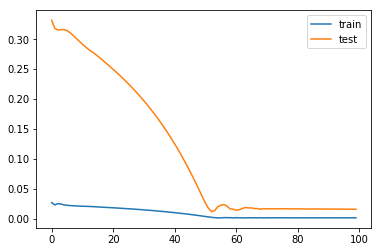

In [597]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

(600, 1)
[0.22133218]


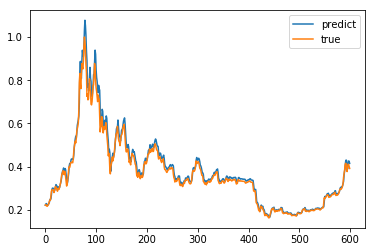

In [598]:
yhat = model.predict(testX) # Here yhat is the predicted value from the test set (y_pred)
print(yhat.shape)
print(yhat[0])

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [599]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(600, 1)
(600, 1)
[4355.0405]
[4358.6626]


In [600]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 489.080


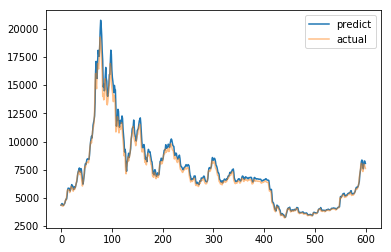

In [601]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

# Nedenunder er sjov og ballade - det har ikke ført til det ønskede og bør bare ignoreres for nu!

In [608]:
Xtest = testX

In [609]:
x = np.zeros((1,1,1))
x[[0]] = yhat[len(yhat)-1][0]
preds = []
#model.reset_states()
for i in range(10):
    yklat = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    #print(yklat)
    preds.append(yklat[0][0])
    #print('X: ', x, ', Y: ', yklat)
    #print(yklat[len(yklat)-1][0])
    y = np.zeros((1,1,1))
    y[[0]] = yklat[len(yklat)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)
    #x[[0]] = yklat[0][0]
    
    #model.reset_states()
    
print(yklat.shape)
print(yklat[0])
print(yklat)

(609, 1)
[0.22133218]
[[0.22133218]
 [0.22612591]
 [0.22899824]
 [0.22541511]
 [0.22120713]
 [0.22090253]
 [0.22582506]
 [0.22837013]
 [0.23501393]
 [0.24494693]
 [0.25002083]
 [0.24984922]
 [0.2678871 ]
 [0.29264417]
 [0.30026495]
 [0.2996244 ]
 [0.29940975]
 [0.29727206]
 [0.2868361 ]
 [0.29560137]
 [0.3072378 ]
 [0.31662542]
 [0.31279695]
 [0.310002  ]
 [0.29908907]
 [0.29341224]
 [0.3059125 ]
 [0.30674195]
 [0.30227593]
 [0.3137025 ]
 [0.32289475]
 [0.3313859 ]
 [0.34721527]
 [0.36879694]
 [0.3787994 ]
 [0.38434446]
 [0.3937437 ]
 [0.38090557]
 [0.3743694 ]
 [0.39103973]
 [0.38588697]
 [0.36298054]
 [0.34230423]
 [0.31856036]
 [0.32939413]
 [0.34703097]
 [0.36833975]
 [0.40186203]
 [0.41395798]
 [0.4098972 ]
 [0.42109406]
 [0.43407154]
 [0.43413487]
 [0.43689325]
 [0.43404463]
 [0.43293262]
 [0.45290554]
 [0.4869125 ]
 [0.51240873]
 [0.5285892 ]
 [0.5406845 ]
 [0.5322867 ]
 [0.55588967]
 [0.591355  ]
 [0.60453   ]
 [0.6162746 ]
 [0.63443255]
 [0.6953861 ]
 [0.8398964 ]
 [0.88722426

In [538]:
yklat

array([[0.20884643],
       [0.21465458],
       [0.21928166],
       ...,
       [8.097132  ],
       [8.097132  ],
       [8.097132  ]], dtype=float32)

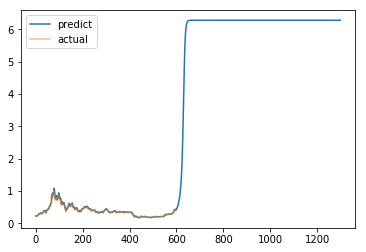

In [606]:
pyplot.plot(yklat, label='predict')
pyplot.plot(testY, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [161]:
data.index[-10:]

DatetimeIndex(['2019-05-11', '2019-05-12', '2019-05-13', '2019-05-14',
               '2019-05-15', '2019-05-16', '2019-05-17', '2019-05-18',
               '2019-05-19', '2019-05-20'],
              dtype='datetime64[ns]', name='time', freq=None)

In [286]:
dates = ['2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31']

future_dates = pd.DataFrame(dates, columns=['time'])
future_dates = future_dates.set_index('time')
future_dates['Weighted_Price'] = 1

In [287]:
values = future_dates['Weighted_Price'].values.reshape(-1,1)
print(values[0])
values = values.astype('float32')
print(values[0])
# Transform values to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
future_datesX = scaler.fit_transform(values)

[1]
[1.]


In [288]:
future_datesX, future_datesY = create_dataset(future_dates, look_back)

TypeError: '(slice(0, 1, None), 0)' is an invalid key

In [266]:
future_dates = np.reshape(future_datesX, (future_datesX.shape[0], 1, future_datesX.shape[1]))

In [280]:
future_dates.shape

(10, 1)

In [268]:
future = model.predict(future_datesX)

AttributeError: 'str' object has no attribute 'ndim'

In [182]:
future = scaler.inverse_transform(future.reshape(-1, 1))

print(future.shape)

print(future[0])

(10, 1)
[0.0031987]
